# Fine-Tuning YOLOv11 for Face Detection
**Author:** Goh Yi Cheng \
**Date:** 20 Oct 2025

This notebook demonstrate the fine-tune on the [YOLOv11](https://huggingface.co/AdamCodd/YOLOv11n-face-detection) (from Hugging Face) using custom dataset.

For this project, the custom dataset was prepared and exported from Roboflow since it provide functionality like:
- Upload and label images for object detection.
- Split data automatically into train, test and validate set.
- Export dataset in YOLO format that make the training process easy and smooth.
- Host and version datasets so that it can be easily downloaded via Roboflow API key.


## Environment setup

In [1]:
!pip install ultralytics --quiet
!pip install roboflow --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 85.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 131.0 MB/s eta 0:00:00


**Roboflow API Key**\
The roboflow API key is obtained from Roboflow account. Once you have the key, store it securely in Colab's Secrets under the name `ROBOFLOW_API_KEY`. This allow you to access the key in code without exposing it directly in the notebook

In [2]:
from google.colab import userdata
Roboflow_API_KEY = userdata.get('ROBOFLOW_API_KEY')

## Download and prepare the Roboflow dataset in YOLO format \
Before running the cell below, make sure the dataset in Roboflow is exported in the `YOLOv11` format.

Step to perform:
1. Go to roboflow project
2. Click "Export Dataset"
3. Select `YOLOv11` under the image and annotations format.

In [3]:
from roboflow import Roboflow
rf = Roboflow(api_key=Roboflow_API_KEY)
project = rf.workspace("yc1012-ekuci").project("face-detection-odcxm")
version = project.version(10)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Face-Detection-10 in yolov11:: 100%|██████████| 278/278 [00:00<00:00, 4688.46it/s]


## Import Pretrained YOLO Face model

In [4]:
from huggingface_hub import hf_hub_download
from ultralytics import YOLO

model_path = hf_hub_download(repo_id="AdamCodd/YOLOv11n-face-detection", filename="model.pt")
model = YOLO(model_path)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.



The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


model.pt:   0%|          | 0.00/5.47M [00:00<?, ?B/s]

## Fine-tuning the model on custom dataset

In [5]:
results = model.train(
    data="/content/Face-Detection-10/data.yaml",
    epochs=100,
    imgsz=640,
    batch=16,
    workers=8,            # Number of data loader workers (threads)
    lr0=0.001,            # lower learning rate for fine-tuning
    freeze=10,            # Nukber of layers to freeze. It helps retain pretrained features
    optimizer="Adam",     # stable fine-tuning optimizer compared to SGD
    project="runs/train",
    name="finetune"
)

Ultralytics 8.3.217 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Face-Detection-10/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/root/.cache/huggingface/hub/models--AdamCodd--YOLOv11n-face-detection/snapshots/ea9d9df2e9ef22ea1cf850fa860c5c0baac33ec1/model.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=finetune, 

## Evaluate model performance

### Training curves (losses, P, R, mAP over epochs)

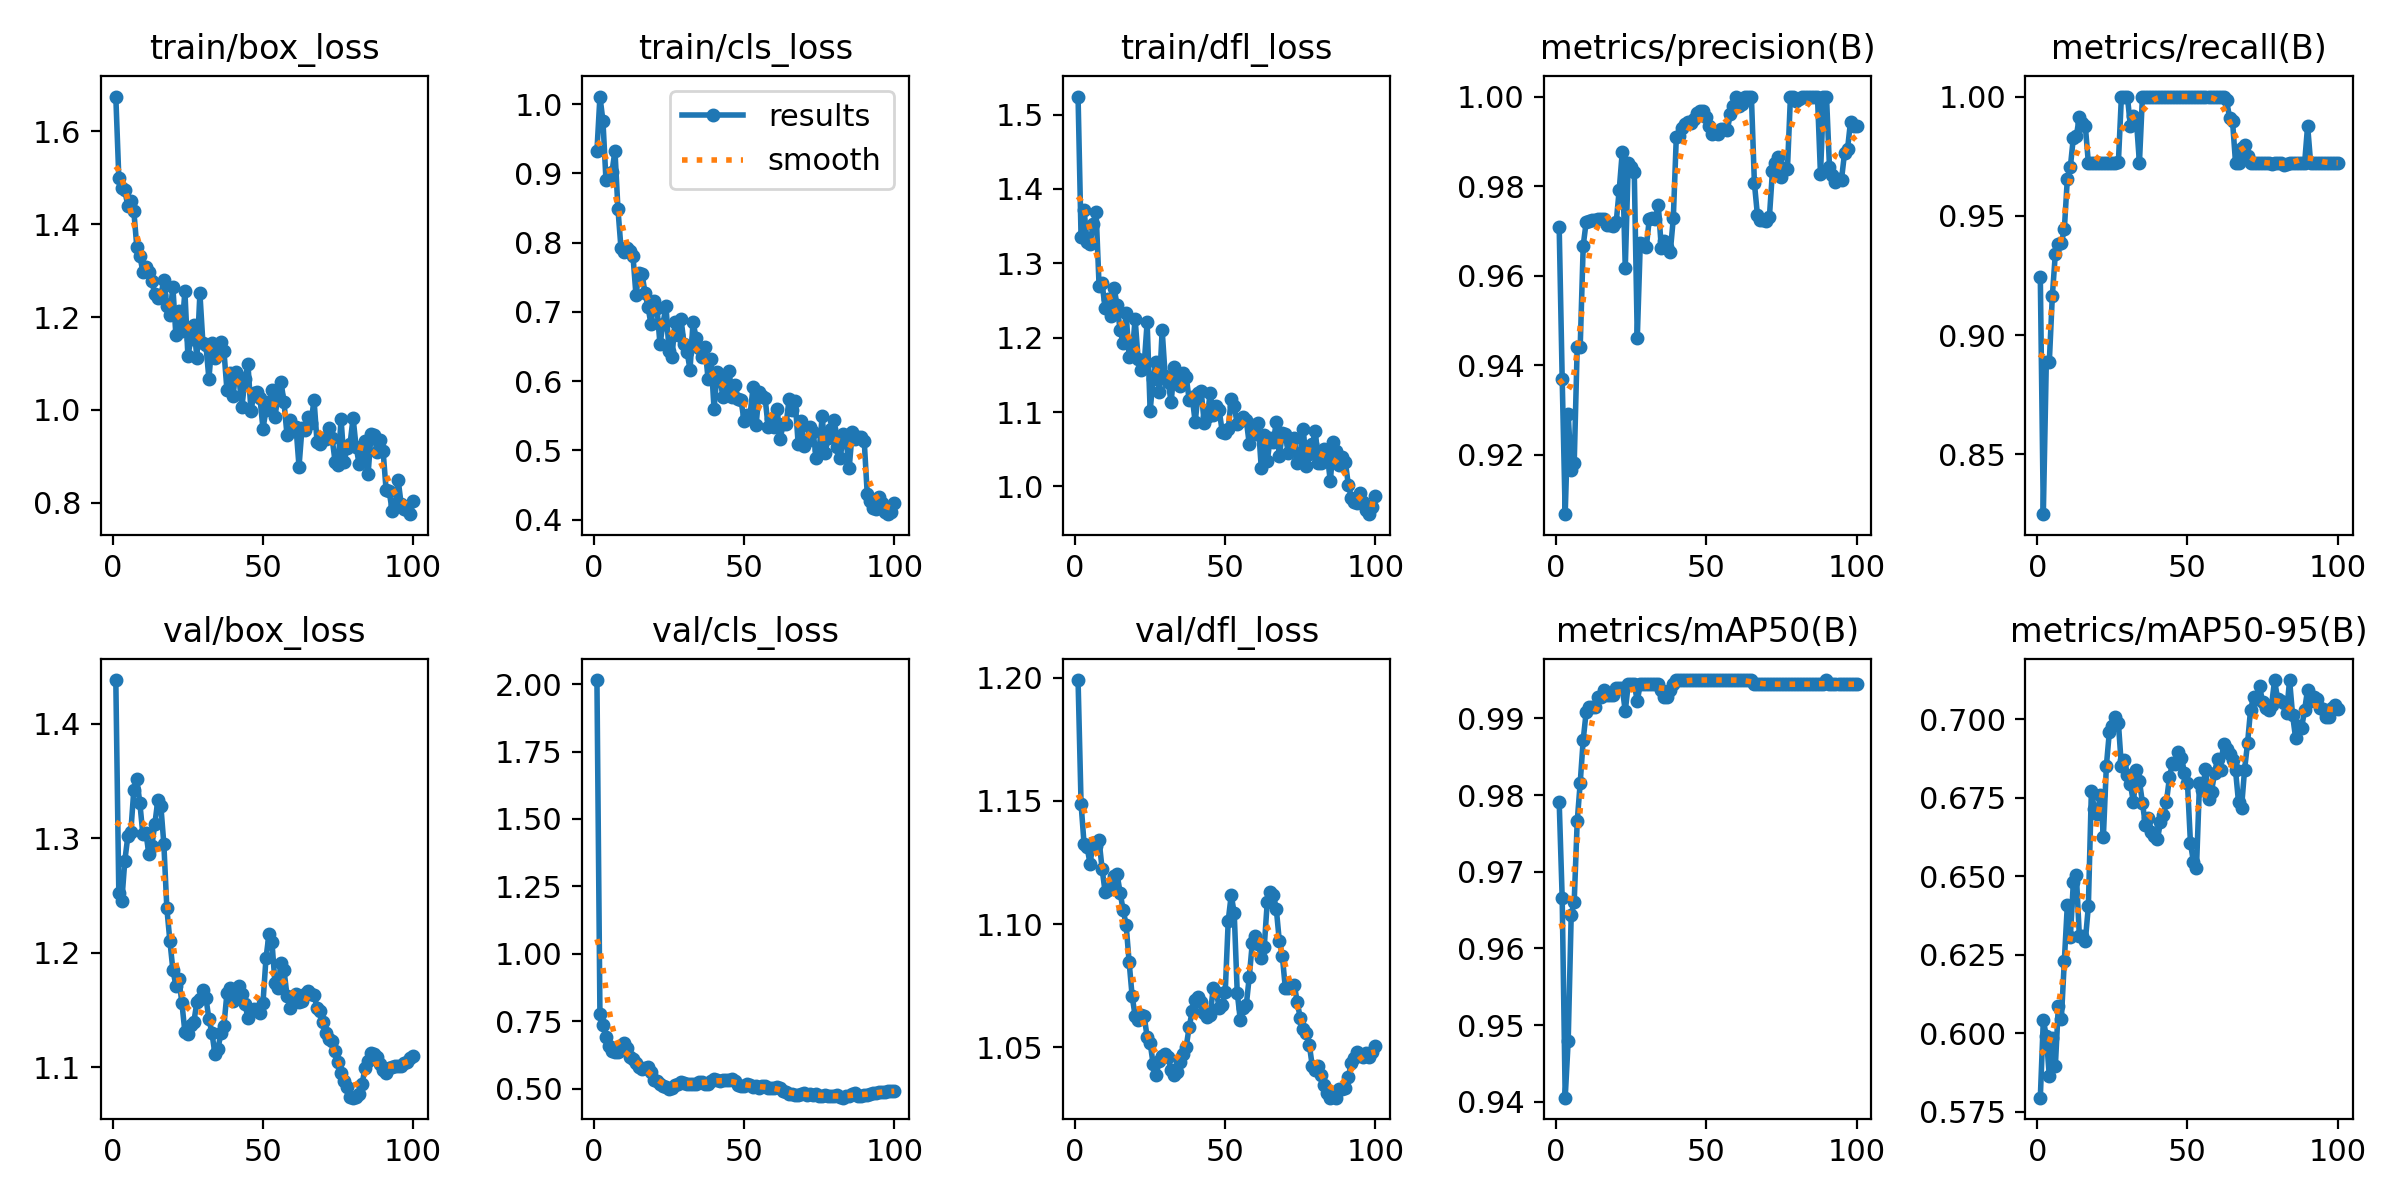

In [6]:
from IPython.display import Image
Image(filename='/content/runs/train/finetune/results.png')

### Confusion matrix

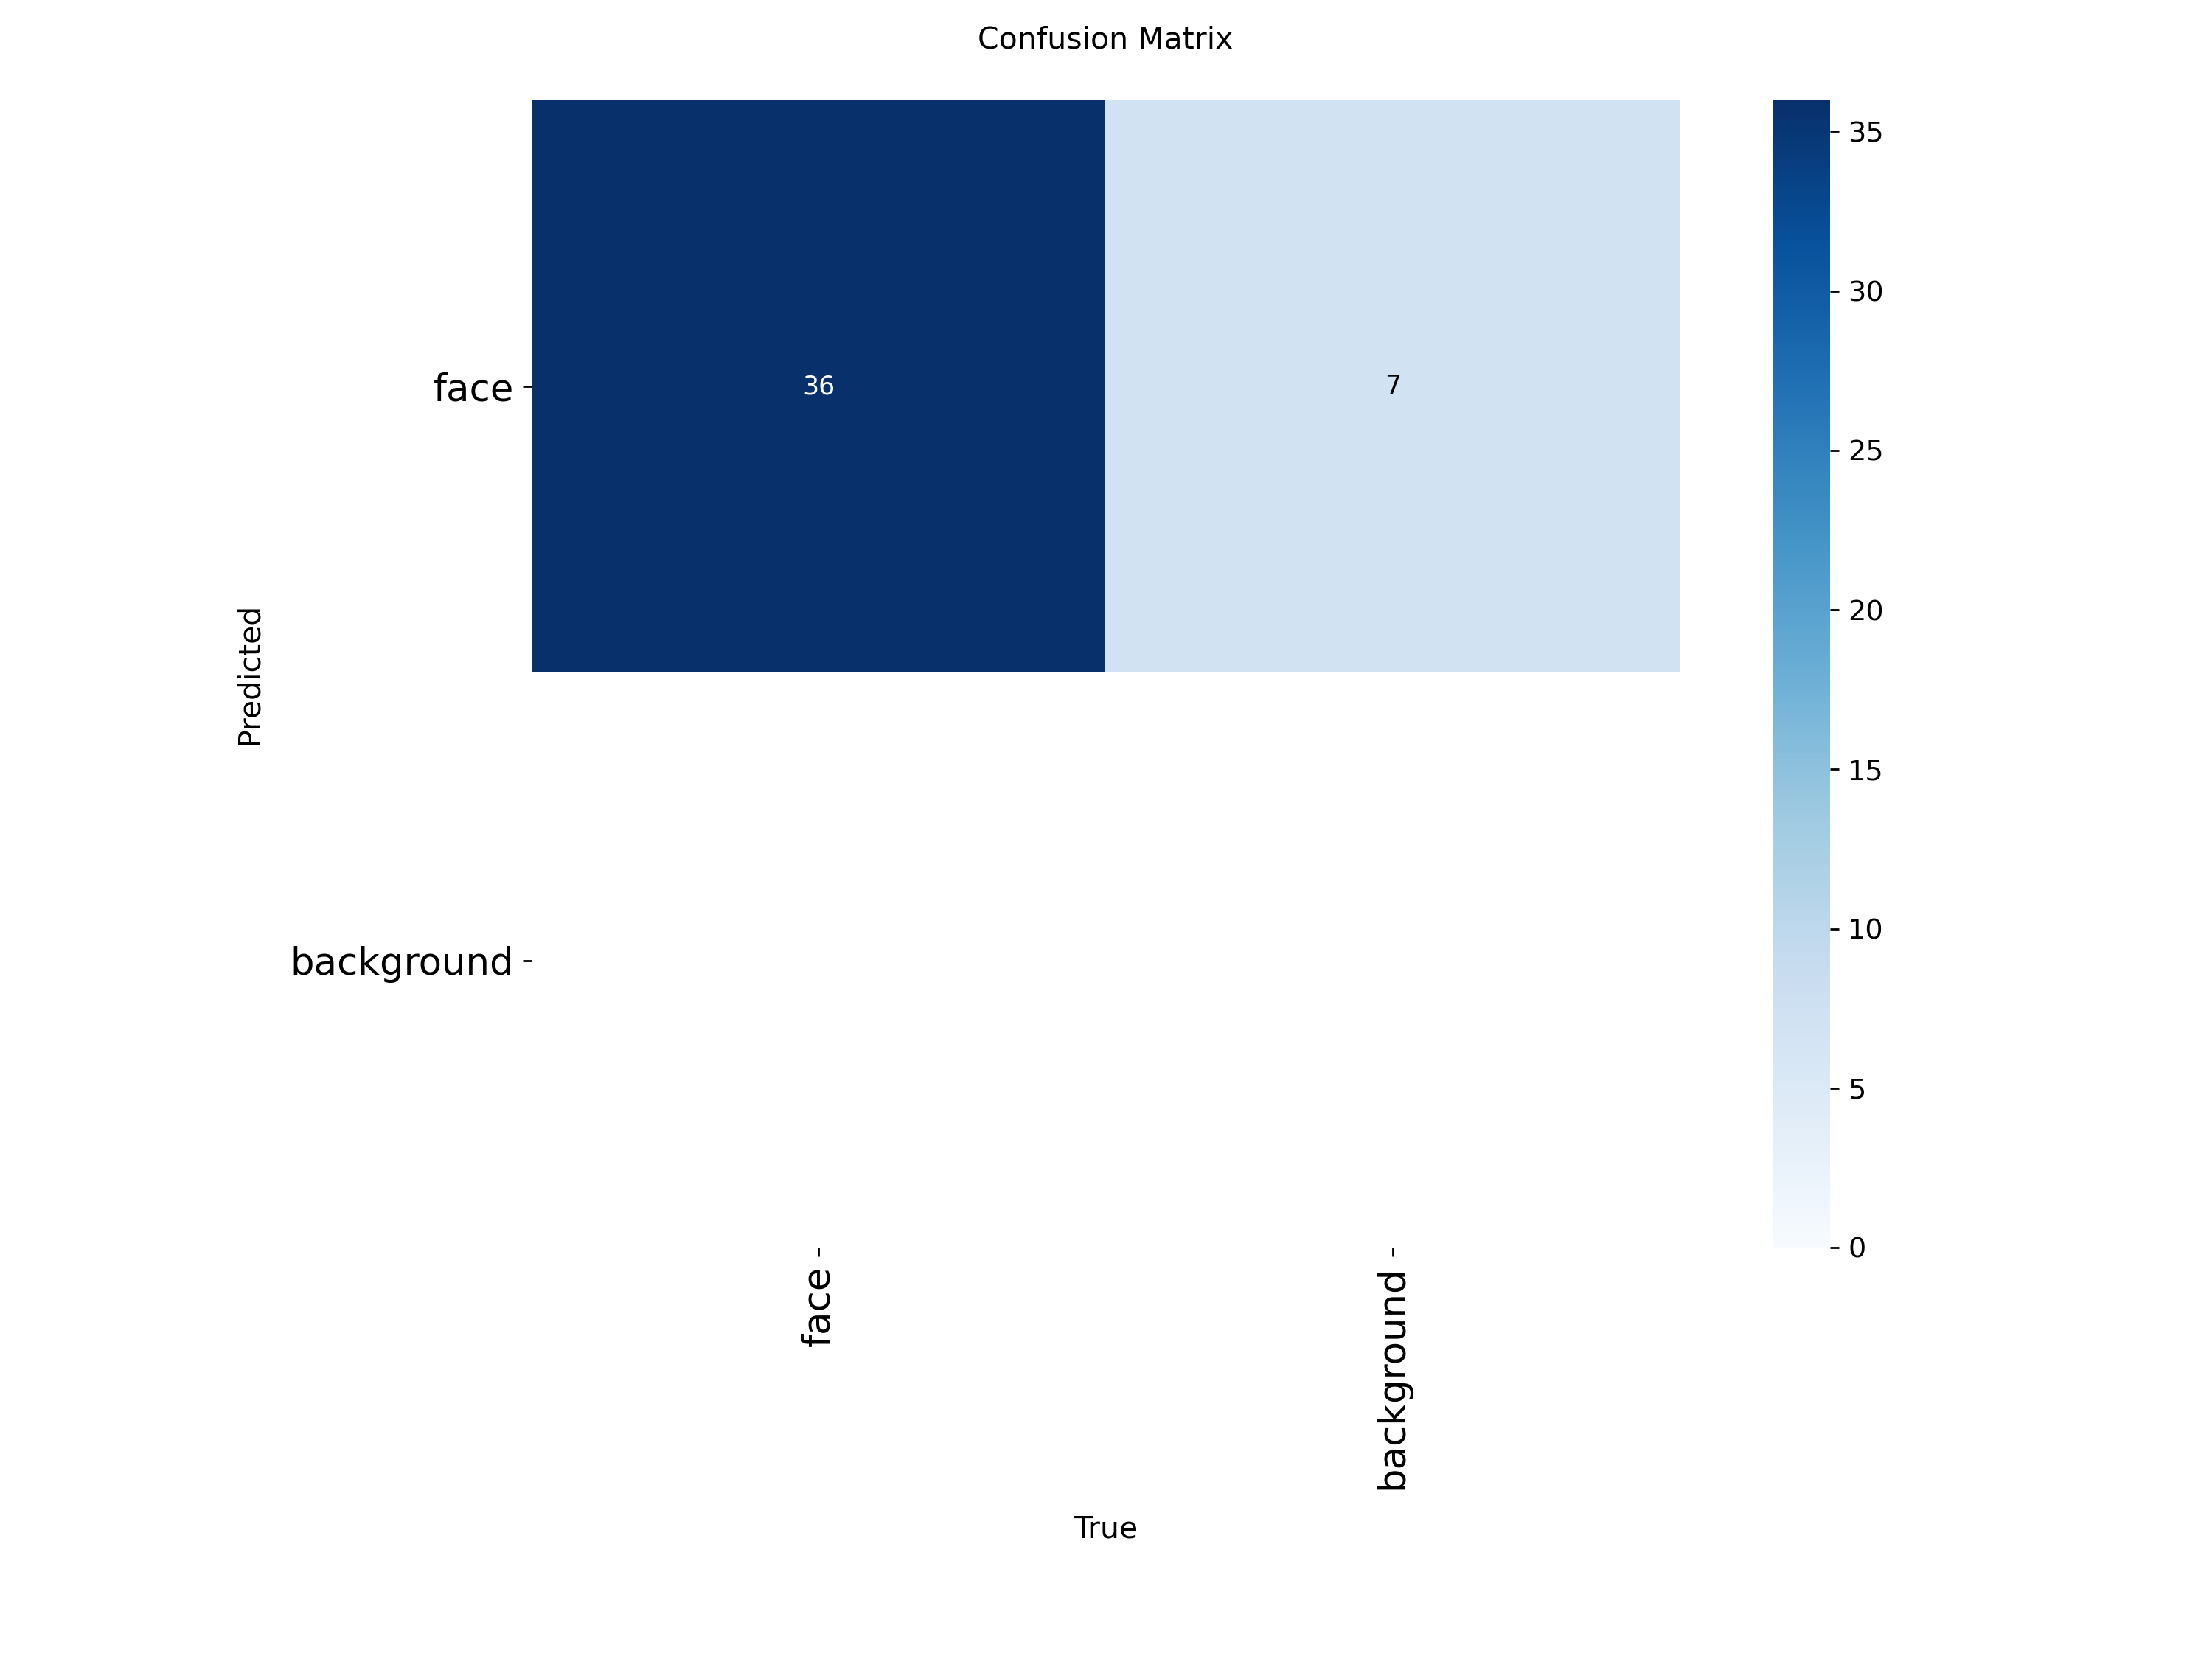

In [8]:
Image(filename='/content/runs/train/finetune/confusion_matrix.png')

### Performance Curve

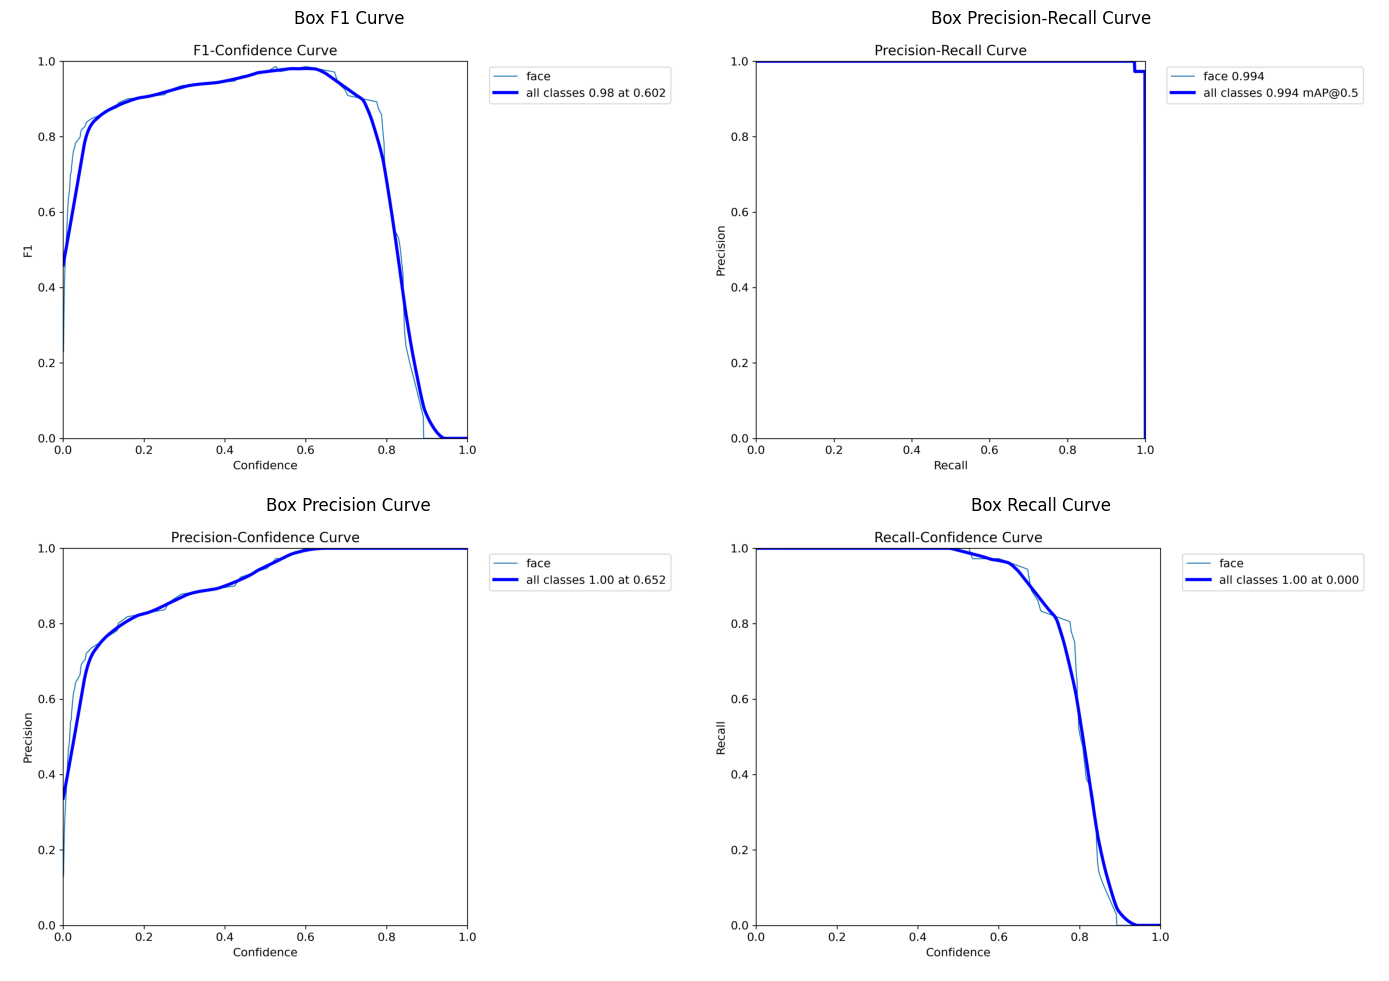

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Paths to your curve images (update the folder path if needed)
f1_path = '/content/runs/train/finetune/BoxF1_curve.png'
pr_path = '/content/runs/train/finetune/BoxPR_curve.png'
p_path  = '/content/runs/train/finetune/BoxP_curve.png'
r_path  = '/content/runs/train/finetune/BoxR_curve.png'

# Load images
f1_img = mpimg.imread(f1_path)
pr_img = mpimg.imread(pr_path)
p_img  = mpimg.imread(p_path)
r_img  = mpimg.imread(r_path)

# Create 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Top-left: F1 Curve
axes[0, 0].imshow(f1_img)
axes[0, 0].set_title('Box F1 Curve')
axes[0, 0].axis('off')

# Top-right: Precision-Recall Curve
axes[0, 1].imshow(pr_img)
axes[0, 1].set_title('Box Precision-Recall Curve')
axes[0, 1].axis('off')

# Bottom-left: Precision Curve
axes[1, 0].imshow(p_img)
axes[1, 0].set_title('Box Precision Curve')
axes[1, 0].axis('off')

# Bottom-right: Recall Curve
axes[1, 1].imshow(r_img)
axes[1, 1].set_title('Box Recall Curve')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()


### Model Information

In [14]:
model.info()

YOLO11n summary: 181 layers, 2,590,035 parameters, 0 gradients, 6.4 GFLOPs


(181, 2590035, 0, 6.4406016)

## Export the model and Download the model

In [7]:
# Download the model directly to local machine
from google.colab import files
files.download('/content/runs/train/finetune/weights/best.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>